# Generate  circles using evolutionary algorithm

The code is based on 
https://github.com/tjwei/play_nsfw, 
which is based on https://scturtle.me/posts/2014-04-18-ga.html 

It depends on DEAP https://deap.readthedocs.io/en/master/

In [1]:
import multiprocessing
from deap import base, creator, tools, algorithms
from PIL import Image, ImageDraw
from random import randint
import skimage



In [2]:
SIZE_X, SIZE_Y = 256, 256
NUMBER_OF_CIRCLES = 30
POPULATION = 50
NGEN = 4000
R = min(SIZE_X, SIZE_Y)//4

In [3]:
def gen_one_circle():
    return (randint(0, SIZE_X), randint(0, SIZE_Y), randint(3, R//4),
            randint(0,255), randint(0,255), randint(0,255), randint(128,255))

In [4]:
creator.create("Fitness", base.Fitness, weights=(1.0,))  # maximize fitness
creator.create("Individual", list, fitness=creator.Fitness)  # individual class

toolbox = base.Toolbox()

toolbox.register("attr", gen_one_circle)  # the above function
toolbox.register("individual", tools.initRepeat,  # initialization of individual
                 creator.Individual, toolbox.attr, NUMBER_OF_CIRCLES)
toolbox.register("population", tools.initRepeat,  # initialization of population
                 list, toolbox.individual)

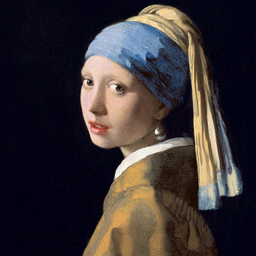

In [5]:
import numpy as np
target_im = Image.open('sample_images/800px-Meisje_met_de_parel.jpg').crop((0,100,800,900)).resize((256,256), Image.LANCZOS)
target_array = np.array(target_im, dtype='float')/255.
target_im

In [6]:
def circles_to_image(circle):
    im = Image.new('RGB', (SIZE_X, SIZE_Y), (0, 0, 0))
    for c in circle:
        mask = Image.new('RGBA', (SIZE_X, SIZE_Y))
        draw = ImageDraw.Draw(mask)
        draw.ellipse((c[0]-c[2], c[1]-c[2], c[0]+c[2], c[1]+c[2]), fill = c[3:], outline =c[3:])
        im.paste(mask, mask=mask)
        del mask, draw
    return im

def evaluate(t2):
    output_im = circles_to_image(t2)
    output_array = np.array(output_im, dtype='float')/255.
    score = skimage.measure.compare_psnr(output_array, target_array, 1.)
    return (score,)

In [7]:
range_table=[(0, SIZE_X-1), (0, SIZE_Y-1), (1, R)]+[(0,255)]*3+[(128, 255)]
def mutate(circles):
    e0 = circles.fitness.values
    for i in range(10):
        tid = randint(0, NUMBER_OF_CIRCLES - 1)
        oldt = circles[tid]
        p = randint(-1, 3 + 4 - 1)
        if p == -1:
            tid2 = randint(0, NUMBER_OF_CIRCLES - 1)
            circles[tid], circles[tid2] = circles[tid2], oldt
        else:
            t = list(oldt)
            t[p] = randint(*range_table[p])
            circles[tid] = tuple(t)
        if evaluate(circles) > e0:
            break
        else:
            if p == -1:
                circles[tid], circles[tid2] = oldt, circles[tid]
            else:
                circles[tid] = oldt
    return [circles]

In [8]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # crossover
toolbox.register("mutate", mutate)  # mutation
toolbox.register("select", tools.selTournament, tournsize=3)

In [9]:
from IPython.display import display, clear_output
import numpy as np
class ipyHOF(tools.HallOfFame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_displayed_fitness = -1
    def insert(self, item):
        if item.fitness.values[0] >= self.last_displayed_fitness+0.001:
            self.last_displayed_fitness = item.fitness.values[0]
            clear_output()
            display(circles_to_image(item))        
        super().insert(item)

In [10]:
pop = toolbox.population(n=POPULATION)
hof = ipyHOF(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("std", np.std)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)

# For multiprocessing
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)


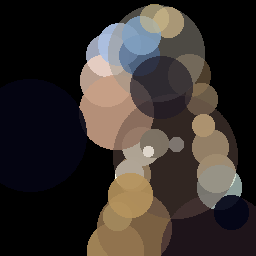

3983	31    	0.286569   	19.3897	19.3406	17.3349
3984	22    	0.16958    	19.3897	19.3494	18.2857
3985	18    	0.00279334 	19.3821	19.3817	19.3621
3986	25    	1.64843e-05	19.3822	19.3821	19.3821
3987	27    	0.0642716  	19.3822	19.3695	18.9754
3988	28    	0.0244843  	19.3846	19.3763	19.2417
3989	26    	0.000720426	19.3848	19.3823	19.3812
3990	31    	0.188043   	19.3848	19.3552	18.0391
3991	25    	0.575643   	19.3848	19.3012	15.2717
3992	31    	0.000816845	19.3849	19.3844	19.3821
3993	24    	0.000263923	19.3849	19.3847	19.3829
3994	39    	4.25774e-05	19.3849	19.3848	19.3846
3995	26    	0.000276529	19.3849	19.3847	19.3829
3996	31    	0.112803   	19.3899	19.3687	18.5791
3997	27    	0.00136195 	19.3899	19.3853	19.3848
3998	27    	0.0021289  	19.3899	19.3861	19.3849
3999	31    	0.154879   	19.39  	19.3539	18.4912
4000	33    	0.306008   	19.3902	19.3439	17.2026


In [11]:
try:
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=NGEN, 
                               stats=stats, halloffame=hof, verbose=True)
except KeyboardInterrupt:
    display(circles_to_image(hof[0]))

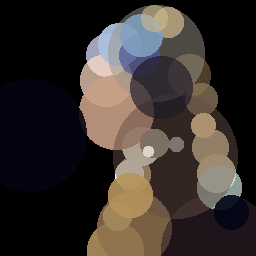

In [12]:
display(circles_to_image(hof[0]))

In [14]:
circles_to_image(hof[0]).save('sample_results/circle-30.png')